# SMAI Assignment - 2

## Question 2: Gaussian Mixture Models

Resources:
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details:
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [2]:
class GMM(object):
    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        # Number of mixture components
        self.n_components = n_components
        # `tol` is the convergence threshold, determining when the EM algorithm should stop iterating.
        self.tol = tol
        # max number of iterations allowed for the EM algorithm
        self.max_iter = max_iter
        # pi
        self.weights = None
        self.means = None
        self.covars = None

    def initialize_params(self, X):
        """
        X : A collection of `N` training data points, each with dimension `d`.
        """
        n_samples, _ = X.shape
        random_indices = np.random.choice(n_samples, size=self.n_components, replace=False)
        self.means = X[random_indices, :]
        self.covars = [np.cov(X.T) for _ in range(self.n_components)]
        self.weights = np.ones(self.n_components) / self.n_components

    def E_step(self, X):
        """
        Find the Expectation of the log-likelihood evaluated using the current estimate for the parameters.
        """
        responsibilities = np.zeros((X.shape[0], self.n_components))

        for i in range(self.n_components):
            try:
                responsibilities[:, i] = self.weights[i] * multivariate_normal.pdf(X, mean=self.means[i], cov=self.covars[i])
            except np.linalg.LinAlgError:
                # Handle the case where the covariance matrix is not positive definite
                # Set responsibilities to a small value for the problematic component
                responsibilities[:, i] = 1e-6

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities


    def M_step(self, X, responsibilities):
      """
      Updates parameters maximizing the expected log-likelihood found on the E step.
      """
      total_weight = responsibilities.sum(axis=0)
      self.weights = total_weight / X.shape[0]

      self.means = np.dot(responsibilities.T, X) / total_weight[:, np.newaxis]

      self.covars = []
      for i in range(self.n_components):
          diff = X - self.means[i]
          covar = np.dot(responsibilities[:, i] * diff.T, diff) / total_weight[i]

          # Add a small regularization term to ensure positive definiteness
          covar += 1e-6 * np.identity(X.shape[1])

          self.covars.append(covar)

    def fit(self, X, y=None):
        """
        Fit the parameters of the GMM on some training data.
        """
        self.initialize_params(X)

        prev_log_likelihood = float('-inf')

        for iteration in range(self.max_iter):
            responsibilities = self.E_step(X)
            self.M_step(X, responsibilities)

            # Calculate log-likelihood and check for convergence
            log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))
            if abs((log_likelihood - prev_log_likelihood) / prev_log_likelihood) < self.tol:
                break

            prev_log_likelihood = log_likelihood


    def predict(self, X):
        """
        Predict the labels for the data samples in X using trained model.
        """
        responsibilities = self.E_step(X)
        return np.argmax(responsibilities, axis=1)

### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

#### Extracting Frames from videos

In [3]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{video}'

In [4]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [5]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [6]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

#### Loading Frames

In [7]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = np.asarray(img, dtype=np.float64)
    img /= 255.0

    frames.append(img)

frames = np.asarray(frames, dtype=np.float64)

#### Splitting the data

In [8]:
print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


In [9]:
print(train_frames[0].shape)

(120, 160, 3)


Display 1st Training Image

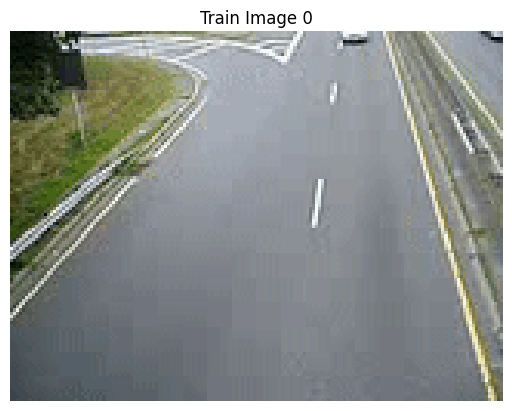

In [10]:
plt.imshow(train_frames[0])
plt.title('Train Image 0')
plt.axis('off')
plt.show()

Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return
```

In [11]:
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return

#### Frame Averaging

Extract Background Image from the training data and display it.

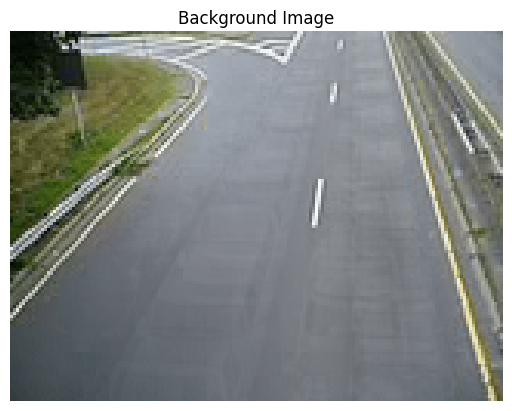

In [12]:
# Your existing code to compute average_frame
average_frame = np.mean(train_frames, axis=0)

# Display the background image
plt.imshow(average_frame)
plt.title('Background Image')
plt.axis('off')
plt.show()

#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

In [ ]:
print(len(train_frames))

48


In [ ]:
print(len(train_frames[0][0]))

160


In [ ]:
first_pixel_values = train_frames[0, 0, 0]

print("Values of the first pixel:", first_pixel_values)

Values of the first pixel: [0.03137255 0.07058824 0.03137255]


In [13]:
pixel_list = []

# Iterate over rows
for row_idx in range(len(train_frames[0])):
    row_list = []  # Initialize a new row list for each row

    # Iterate over columns
    for col_idx in range(len(train_frames[0][row_idx])):
        col_values = []  # Initialize a new list for each column

        # Iterate over frames
        for frame_idx in range(len(train_frames)):
            pixel_values = train_frames[frame_idx, row_idx, col_idx]
            col_values.append(pixel_values)

        # Append the list of pixel values for the current position to the row list
        row_list.append(col_values)

    # Append the row list to the pixel_list
    pixel_list.append(row_list)


In [16]:
print(len(pixel_list[0][0]))

48


In [15]:
print((pixel_list[0][0][0]))

[0.03137255 0.07058824 0.03137255]


In [14]:
np.array(pixel_list[row_idx][col_idx])

array([[0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.37254902, 0.36862745, 0.2       ],
       [0.37254902, 0.36862745, 0.2       ],
       [0.3254902 , 0.32941176, 0.20784314],
       [0.3254902 , 0.32941176, 0.20784314],
       [0.3254902 , 0.32941176, 0.20784314],
       [0.3254902 , 0.32941176, 0.20784314],
       [0.3254902 , 0.32941176, 0.20784314],
       [0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.4       , 0.38823529, 0.29019608],
       [0.

In [17]:
len(pixel_list[0])

160

In [18]:
# Print the number of row_idx and col_idx
print("Number of row_idx:", len(pixel_list))
print("Number of col_idx:", len(pixel_list[0]))


Number of row_idx: 120
Number of col_idx: 160


In [19]:
# Number of components in the GMM
num_components = 2

# Create a list to store GMMs for each pixel
pixel_gmms = []

# Fit GMM for each pixel's data in pixel_list
for row_idx in range(len(pixel_list)):
    # Iterate over columns
    for col_idx in range(len(pixel_list[0])):
        X = np.array(pixel_list[row_idx][col_idx])

        # Create an instance of the GMM class
        gmm = GMM(n_components=num_components, tol=1e-3, max_iter=100)

        # Reshape X to make it a 2D array with 3 columns (assuming each pixel_list[row_idx][col_idx] has 3 values)
        X = X.reshape(-1, 3)

        # Fit the model on your data
        gmm.fit(X)

        pixel_gmms.append(gmm)

<ipython-input-2-3d66c56606ad>:75: RuntimeWarning: invalid value encountered in scalar divide
  if abs((log_likelihood - prev_log_likelihood) / prev_log_likelihood) < self.tol:
<ipython-input-2-3d66c56606ad>:75: RuntimeWarning: divide by zero encountered in scalar divide
  if abs((log_likelihood - prev_log_likelihood) / prev_log_likelihood) < self.tol:


Print the Multivariate Normal Distribution Parameters for 1st pixel

In [20]:
if pixel_gmms:
    first_gmm = pixel_gmms[0]

    print("Weights:", first_gmm.weights)
    print("Means:", first_gmm.means)
    print("Covars:", first_gmm.covars)
else:
    print("pixel_gmms is empty.")

Weights: [0.5 0.5]
Means: [[0.02312092 0.05555556 0.02843137]
 [0.02312092 0.05555556 0.02843137]]
Covars: [array([[1.06241307e-04, 1.88015293e-04, 4.49346405e-05],
       [1.88015293e-04, 3.47234354e-04, 5.95924644e-05],
       [4.49346405e-05, 5.95924644e-05, 6.15536332e-05]]), array([[1.06241307e-04, 1.88015293e-04, 4.49346405e-05],
       [1.88015293e-04, 3.47234354e-04, 5.95924644e-05],
       [4.49346405e-05, 5.95924644e-05, 6.15536332e-05]])]


#### Extract Background Image from the trained model

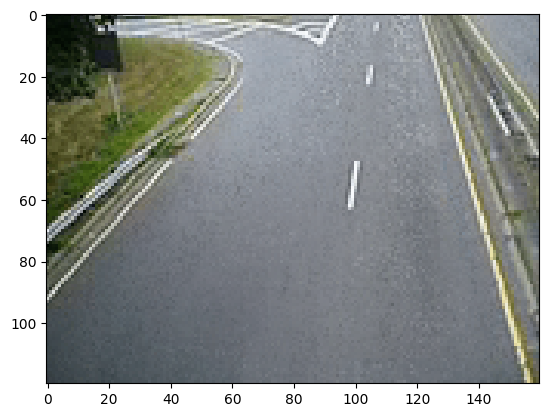

In [21]:
# Create an empty image array
image_shape = (len(pixel_list), len(pixel_list[0]), 3)
background_image = np.zeros(image_shape, dtype=np.uint8)

# Iterate over pixels
for row_idx in range(len(pixel_list)):
    for col_idx in range(len(pixel_list[0])):
        X = np.array(pixel_list[row_idx][col_idx]).reshape(-1, 3)

        # Get the GMM for the current pixel
        current_gmm = pixel_gmms[row_idx * len(pixel_list[0]) + col_idx]

        # Assign each pixel to the component with higher weight
        assigned_component = np.argmax(current_gmm.weights)

        # Use the mean values of the assigned component as RGB values
        rgb_values = (current_gmm.means[assigned_component])*255

        # Update the background_image array
        background_image[row_idx, col_idx, :] = rgb_values

# Display the resulting background image
plt.imshow(background_image)
plt.show()

### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [22]:
# helper functions
from google.colab.patches import cv2_imshow
import time
import os

def display_frames_colab(frames, fps=10.0):
    """
    Display the frames as a video in Colab.
    """
    eps = 0.0001

    wait_time = 1 / fps

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2_imshow(frame)
        time.sleep(wait_time)


def save_frames_colab(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video in Colab.
    """
    eps = 0.0001

    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")

    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2_imshow(frame)
        time.sleep(wait_time)

        vid_wrt.write(frame)

    vid_wrt.release()

#### Frame Averaging

In [42]:
foreground_frames_restored = []

# Iterate through the test set
for frame_idx in range(len(test_frames)):
    test_frame_normalized = test_frames[frame_idx]

    # Restore normalized values by multiplying with 255
    test_frame_restored = test_frame_normalized * 255

    # Subtract the average_frame from the restored test frame
    foreground_frame_restored = test_frame_restored - average_frame*255

    # Ensure that the values are within the valid range [0, 255]
    foreground_frame_restored = np.clip(foreground_frame_restored, 0, 255)

    # Append the restored foreground frame to the list
    foreground_frames_restored.append(foreground_frame_restored)

# Convert the list of foreground frames to a NumPy array
foreground_frames_restored = np.array(foreground_frames_restored)


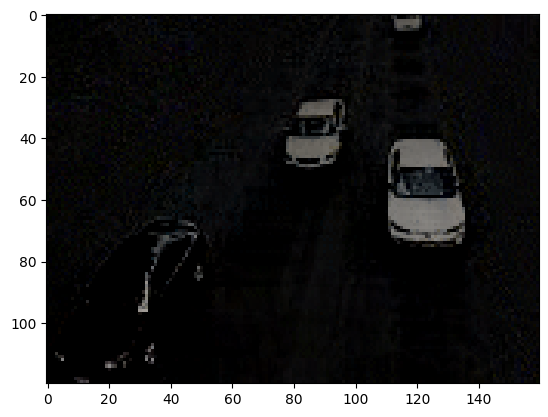

First test foreground_frames_restored: (32, 120, 160, 3)


In [43]:
# Display one of the restored foreground frames (e.g., the first one)
plt.imshow(foreground_frames_restored[0].astype(np.uint8))
plt.show()

# Print the shape of the resulting restored foreground frames array
print(f'First test foreground_frames_restored: {foreground_frames_restored.shape}')

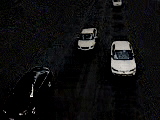

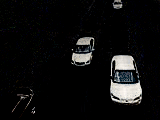

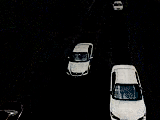

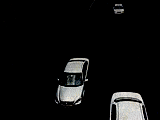

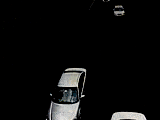

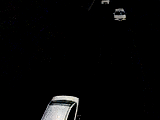

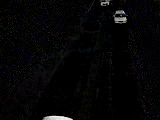

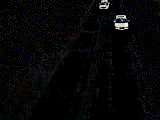

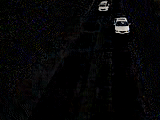

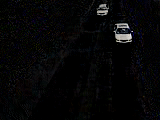

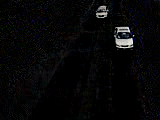

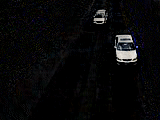

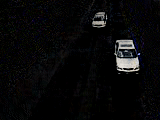

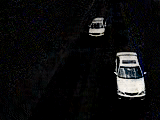

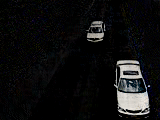

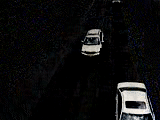

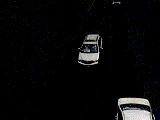

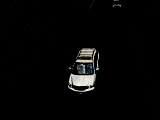

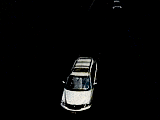

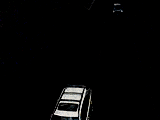

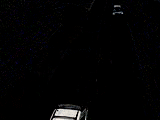

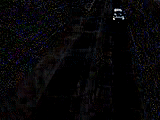

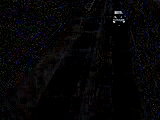

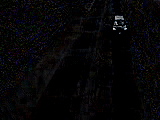

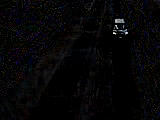

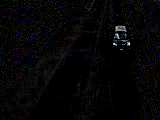

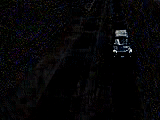

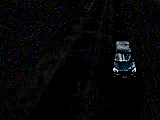

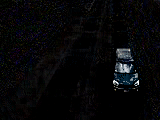

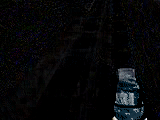

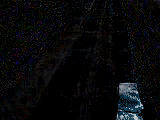

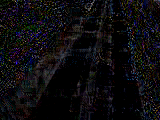

In [44]:
display_frames_colab(foreground_frames_restored, fps=10.0)

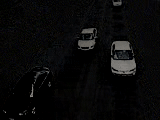

In [45]:
# Assuming foreground_frames_restored is a list of frames
gif_path = '/content/foreground_frames_AVGFrame.gif'

# Convert frames to uint8 format
converted_frames = [frame.astype(np.uint8) for frame in foreground_frames_restored]

# Save the GIF
imageio.mimsave(gif_path, converted_frames, fps=10)

# Display the GIF
from IPython.display import display, Image

# Display the GIF
display(Image(data=gif_path, format="png"))

#### GMMs per pixel

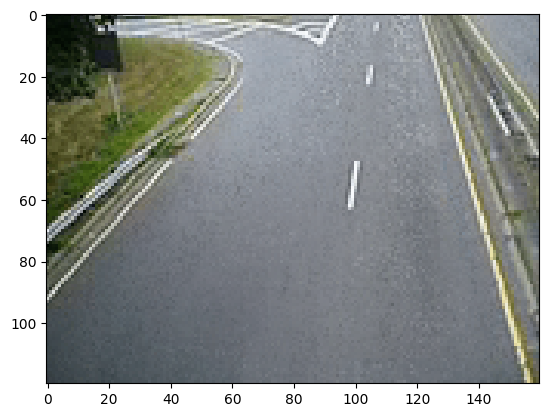

In [46]:
# Create an empty image array
image_shape = (len(pixel_list), len(pixel_list[0]), 3)
background_image = np.zeros(image_shape, dtype=np.uint8)

# Iterate over pixels
for row_idx in range(len(pixel_list)):
    for col_idx in range(len(pixel_list[0])):
        X = np.array(pixel_list[row_idx][col_idx]).reshape(-1, 3)

        # Get the GMM for the current pixel
        current_gmm = pixel_gmms[row_idx * len(pixel_list[0]) + col_idx]

        # Assign each pixel to the component with higher weight
        assigned_component = np.argmax(current_gmm.weights)

        # Use the mean values of the assigned component as RGB values
        rgb_values = (current_gmm.means[assigned_component])*255

        # Update the background_image array
        background_image[row_idx, col_idx, :] = rgb_values

# Display the resulting background image
plt.imshow(background_image)
plt.show()

In [47]:
foreground_frames_restored = []

# Iterate through the test set
for frame_idx in range(len(test_frames)):
    test_frame_normalized = test_frames[frame_idx]

    # Restore normalized values by multiplying with 255
    test_frame_restored = test_frame_normalized * 255

    # Subtract the background_image from the restored test frame
    foreground_frame_restored = test_frame_restored - background_image

    # Ensure that the values are within the valid range [0, 255]
    foreground_frame_restored = np.clip(foreground_frame_restored, 0, 255)

    # Append the restored foreground frame to the list
    foreground_frames_restored.append(foreground_frame_restored)

# Convert the list of foreground frames to a NumPy array
foreground_frames_restored = np.array(foreground_frames_restored)

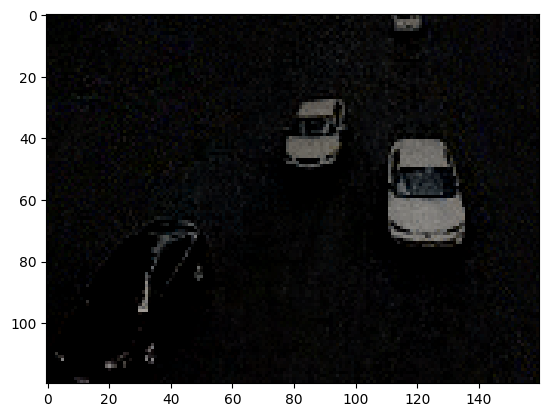

First test foreground_frames_restored: (32, 120, 160, 3)


In [48]:
# Display one of the restored foreground frames (e.g., the first one)
plt.imshow(foreground_frames_restored[0].astype(np.uint8))
plt.show()

# Print the shape of the resulting restored foreground frames array
print(f'First test foreground_frames_restored: {foreground_frames_restored.shape}')

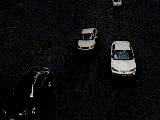

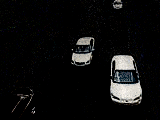

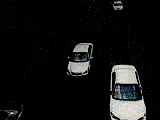

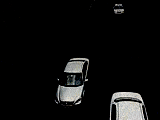

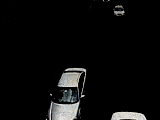

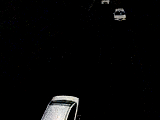

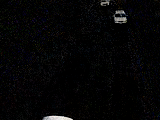

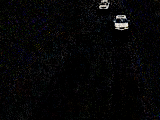

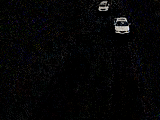

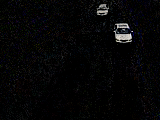

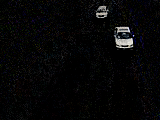

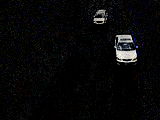

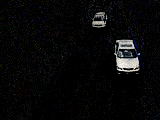

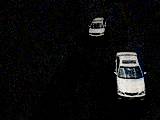

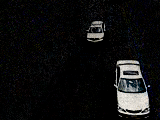

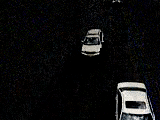

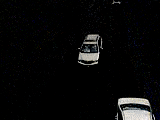

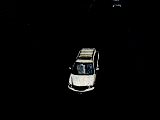

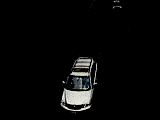

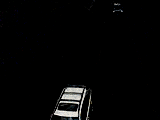

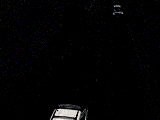

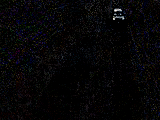

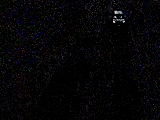

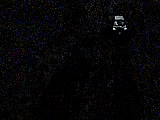

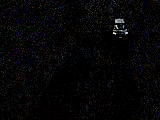

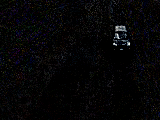

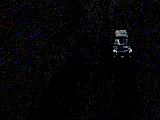

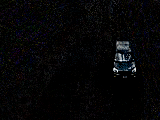

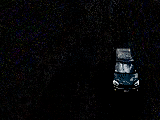

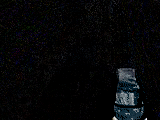

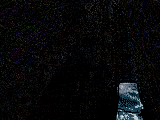

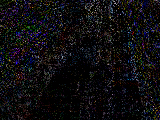

In [49]:
display_frames_colab(foreground_frames_restored, fps=10.0)

### Displaying the Foreground GIF

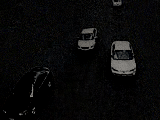

In [50]:
# Assuming foreground_frames_restored is a list of frames
gif_path = '/content/foreground_frames_GMMPerPixel.gif'

# Convert frames to uint8 format
converted_frames = [frame.astype(np.uint8) for frame in foreground_frames_restored]

# Save the GIF
imageio.mimsave(gif_path, converted_frames, fps=10)

# Display the GIF
from IPython.display import display, Image

# Display the GIF
display(Image(data=gif_path, format="png"))